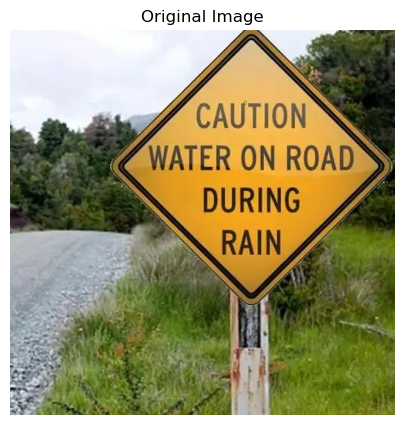

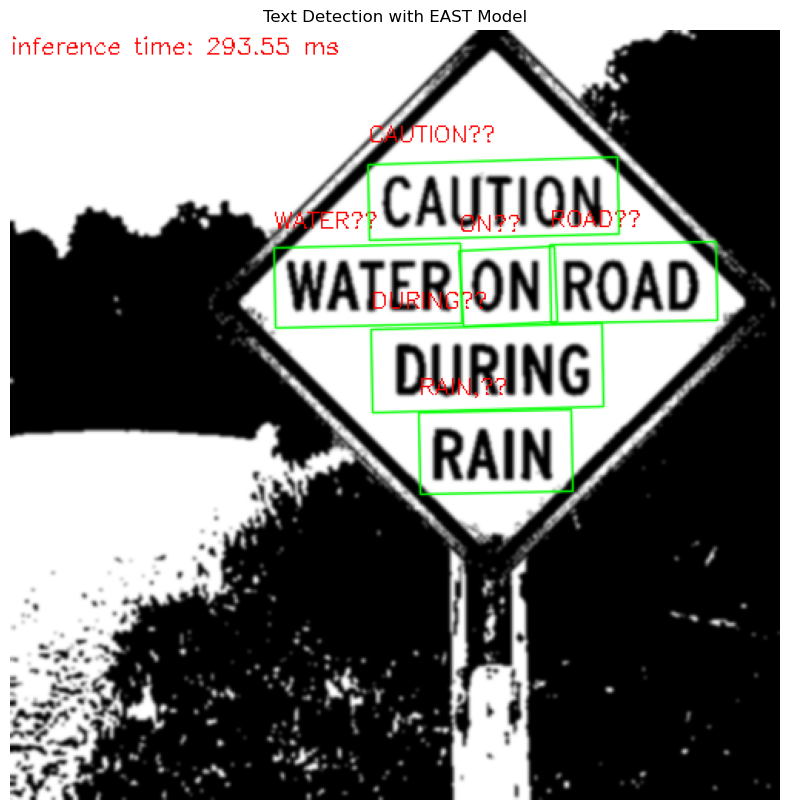

In [6]:
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt
import pytesseract

# Set the path for Tesseract.
pytesseract.pytesseract.tesseract_cmd = r'D:\Tesseract-OCR\tesseract.exe'
tessdata_dir_config = r'--tessdata-dir D:\Tesseract-OCR\tessdata'

def decode(scores, geometry, scoreThresh):
    detections = []
    confidences = []

    ############ CHECK DIMENSIONS AND SHAPES OF geometry AND scores ############
    assert len(scores.shape) == 4, "Incorrect dimensions of scores"
    assert len(geometry.shape) == 4, "Incorrect dimensions of geometry"
    assert scores.shape[0] == 1, "Invalid dimensions of scores"
    assert geometry.shape[0] == 1, "Invalid dimensions of geometry"
    assert scores.shape[1] == 1, "Invalid dimensions of scores"
    assert geometry.shape[1] == 5, "Invalid dimensions of geometry"
    assert scores.shape[2] == geometry.shape[2], "Invalid dimensions of scores and geometry"
    assert scores.shape[3] == geometry.shape[3], "Invalid dimensions of scores and geometry"
    height = scores.shape[2]
    width = scores.shape[3]
    for y in range(0, height):

        # Extract data from scores
        scoresData = scores[0][0][y]
        x0_data = geometry[0][0][y]
        x1_data = geometry[0][1][y]
        x2_data = geometry[0][2][y]
        x3_data = geometry[0][3][y]
        anglesData = geometry[0][4][y]
        for x in range(0, width):
            score = scoresData[x]

            # If score is lower than threshold score, move to next x
            if(score<scoreThresh):
                continue

            # Calculate offset
            offsetX = x * 4.0
            offsetY = y * 4.0
            angle = anglesData[x]

            # Calculate cos and sin of angle
            cosA = math.cos(angle)
            sinA = math.sin(angle)
            h = x0_data[x] + x2_data[x]
            w = x1_data[x] + x3_data[x]

            # Calculate offset
            offset = ([offsetX + cosA * x1_data[x] + sinA * x2_data[x], offsetY - sinA * x1_data[x] + cosA * x2_data[x]])

            # Find points for rectangle
            p1 = (-sinA * h + offset[0], -cosA * h + offset[1])
            p3 = (-cosA * w + offset[0],  sinA * w + offset[1])
            center = (0.5*(p1[0]+p3[0]), 0.5*(p1[1]+p3[1]))
            detections.append((center, (w,h), -1*angle * 180.0 / math.pi))
            confidences.append(float(score))

    # Return detections and confidences
    return [detections, confidences]

modelpath = "frozen_east_text_detection.pb"

net = cv2.dnn.readNetFromTensorflow(modelpath)
names = net.getLayerNames()
outNames = ['feature_fusion/Conv_7/Sigmoid', 'feature_fusion/concat_3']
inputsize = (320,320)

# input need 3 channels
img = cv2.imread('img5.jpg',1)  
orimg = img
if img is None:
    print("Error: Image not found or unable to read.")
else:
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply threshold processing
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(thresh, (5, 5), 0)

    # Apply edge detection
    edges = cv2.Canny(blurred, 50, 150)

    # Convert the image back to BGR format for further processing
    img = cv2.cvtColor(blurred, cv2.COLOR_GRAY2BGR)
    
    height = img.shape[0]
    width = img.shape[1]
    rW = width / float(inputsize[0])
    rH = height /float(inputsize[1])
    confThreshold = 0.5
    nmsThreshold = 0.4 
    scalefactor = 1.0
    meanval = (123.68, 116.78, 103.94)
    # pre proc
    blob = cv2.dnn.blobFromImage(img,scalefactor,inputsize,meanval,  True,False)
    net.setInput(blob)
    out = net.forward(outNames)
    t,_ = net.getPerfProfile()
    label  = "inference time: %.2f ms"%(t*1000.0/cv2.getTickFrequency())
    
    scores = out[0]
    geometry = out[1]
    [boxes, confidences] = decode(scores, geometry, confThreshold)
    
    #print(rW,rH)
    frame = img
    
    # Apply NMS
    indices = cv2.dnn.NMSBoxesRotated(boxes, confidences, confThreshold,nmsThreshold)
    
    for i in indices:
        ri = lambda x: int(round(x))
        # get 4 corners of the rotated rect
        vertices = cv2.boxPoints(boxes[i])
        #print("vertices:", vertices)
        # scale the bounding box coordinates based on the respective ratios
        for j in range(4):
            vertices[j][0] *= rW
            vertices[j][1] *= rH
            if j == 0 or j == 1:
                vertices[j][0] -=6
            else:
                vertices[j][0] +=6
            if j == 1 or j == 2:
                vertices[j][1] -=6
            else:
                vertices[j][1] +=6
        for j in range(4):
            p1 = (ri(vertices[j][0]), ri(vertices[j][1]))
            p2 = (ri(vertices[(j + 1) % 4][0]), ri(vertices[(j + 1) % 4][1]))
            cv2.line(frame, p1, p2, (0, 255, 0), 1, cv2.LINE_AA);
            
        # Use Tesseract for OCR
        y1,y2,x1,x2 = ri(vertices[2][1]), ri(vertices[0][1]), ri(vertices[1][0]), ri(vertices[3][0])
        roi = frame[y1:y2, x1:x2]
        text = pytesseract.image_to_string(roi, lang='eng', config=tessdata_dir_config)
        cv2.putText(frame, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

    # Put efficiency information
    label  = "inference time: %.2f ms"%(t*1000.0/cv2.getTickFrequency())
    cv2.putText(frame, label, (0, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

    # Convert the BGR image to RGB
    img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Display the image using matplotlib
    plt.figure(figsize=(5, 5))
    plt.imshow(cv2.cvtColor(orimg, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')  # Turn off the axis
    plt.show()
    
    plt.figure(figsize=(10, 10))
    plt.imshow(img_rgb)
    plt.title('Text Detection with EAST Model')
    plt.axis('off')  # Turn off the axis
    plt.show()
